In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import timm


print("Done!")

Done!


In [2]:
class CFG():
    SEED = 42
    BATCH_SIZE = 50
    DEVICE = 'cuda'
    EPOCHS = 100
    TOTAL_BATCH_SIZE = BATCH_SIZE * 2

In [3]:
train_real = "./train/real_images"
train_fake = "./train/fake_images"

new_real = "./new_real"
new_fake = "./new_fake"

In [4]:
real_ids = os.listdir(os.path.join(train_real))
fake_ids = os.listdir(os.path.join(train_fake))

new_real_ids = os.listdir(os.path.join(new_real))
new_fake_ids = os.listdir(os.path.join(new_fake))

In [5]:
real = list(map(lambda x: os.path.join(train_real, x), real_ids))
fake = list(map(lambda x: os.path.join(train_fake, x), fake_ids))

new_real = sorted(list(map(lambda x: os.path.join(new_real, x), new_real_ids)))[1:]
new_fake = sorted(list(map(lambda x: os.path.join(new_fake, x), new_fake_ids)))[1:]

In [6]:
df = pd.DataFrame({"id": real+fake, "label": [0]*len(real)+[1]*len(fake)})
df.head()

,id,label
0,./train/real_images/real_04877.png,0
1,./train/real_images/real_01858.png,0
2,./train/real_images/real_07766.png,0
3,./train/real_images/real_03833.png,0
4,./train/real_images/real_06072.png,0


In [7]:
df.label.value_counts()

0    10000
1    10000
Name: label, dtype: int64

In [8]:
df2 = pd.DataFrame({"id": new_real+new_fake, "label": [0]*len(new_real)+[1]*len(new_fake)})
df2.head()

,id,label
0,./new_real/0.jpg,0
1,./new_real/1.jpg,0
2,./new_real/10.jpg,0
3,./new_real/100.jpg,0
4,./new_real/1000.jpg,0


In [9]:
new_df = pd.concat([df, df2]).reset_index(drop=True)

In [10]:
new_df.tail()

,id,label
23524,./new_fake/ffb7497c-c267-44fd-8aff-9ce17fb42c9...,1
23525,./new_fake/ffd3454d-3570-4a6b-892b-9ac3c8f1d2e...,1
23526,./new_fake/ffe50c04-1c78-49e3-b6f3-f48a4d185e1...,1
23527,./new_fake/ffe51cc0-8dd5-4a0c-8022-2a32057b4fd...,1
23528,./new_fake/ffff0828-b9bf-46b3-ac79-67724621a0f...,1


In [11]:
new_df.label.value_counts()

1    12000
0    11529
Name: label, dtype: int64

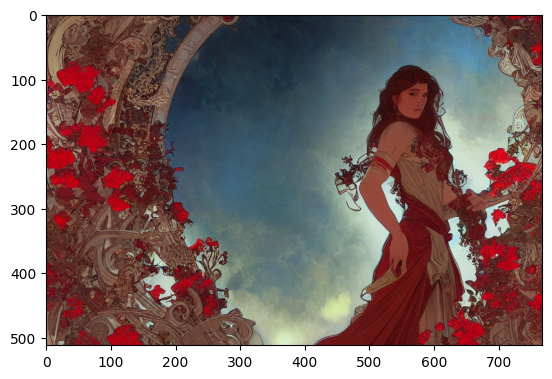

In [12]:
img = cv2.cvtColor(cv2.imread(new_df.iloc[-10, 0]), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [13]:
img.shape

(512, 768, 3)

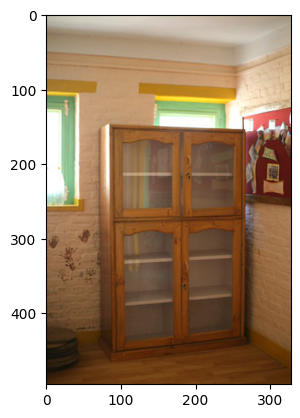

In [14]:
img = cv2.cvtColor(cv2.imread(new_df.iloc[0, 0]), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [15]:
img.shape

(496, 328, 3)

In [16]:
# for index, row in df.iterrows():
#     srcBGR = cv2.imread(row['id'])
#     cv2.imwrite(row['id'], srcBGR)

In [17]:
# # --------------------------------- #
# #         Data Sanity Check         #
# # --------------------------------- #
# def data_sanity_check(df):
#     """
#         this will check each image file for corrupted or missing and 
#         returns index of corrupted / missing files .Doing this will
#         prevent us from running into any errors during training phase .
#     """
#     idx = []
#     start = time.time()
#     for i in range(len(df)):
#         try:#       checks for corrupeted or missing image files
#             if len(cv2.imread(df.iloc[i,0])) == 3:
#                 _ = 1
#         except:
#             print(i)
#             idx.append(df.iloc[i,0])
#     end = time.time()
#     print(end-start)
#     return idx

In [18]:
# dsc = data_sanity_check(df)

In [19]:
train_df = df
# train_df = new_df

In [20]:
# # number of training files after data sanity check
# train_df = df[~df["id"].isin(dsc)]
# train_df

In [21]:
# --------------------------------- #
#             Dataset               #
# --------------------------------- #


class ImageDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 1]
        if self.transforms:
            return self.transforms(img), torch.Tensor([label])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.
        # img = cv2.resize(img, (384, 384))
        return torch.Tensor(img).permute([2, 1, 0]), torch.Tensor([label])

In [22]:
train_set, val_set = train_test_split(train_df, test_size=0.1,
                                      random_state=CFG.SEED,
                                      stratify=train_df["label"])

In [23]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 384)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
train_dataset = ImageDataset(train_set, transforms)
val_dataset = ImageDataset(val_set, transforms)

In [24]:
# -------------------------------- #
#           DataLoaders            #
# -------------------------------- #
train_dataloader = DataLoader(train_dataset,
                              batch_size=CFG.BATCH_SIZE,
                              shuffle=True,)
val_dataloader = DataLoader(val_dataset,
                            batch_size=CFG.BATCH_SIZE,
                            shuffle=False,)

In [25]:
# timm.list_models("resnet*")

In [26]:
backbone = timm.create_model("vit_base_patch32_384", pretrained=True, num_classes=0)

In [27]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.min_loss = np.inf

    def __call__(self, train_loss, validation_loss=None):
        if train_loss < self.min_loss:
            self.counter = 0
            self.min_loss = train_loss
            print(f'Early stop : set 0/{self.tolerance} min loss : {self.min_loss}')
        elif train_loss > self.min_loss:
            self.counter += 1
            print(f'Early stop : {self.counter}/{self.tolerance}')
        if self.counter >= self.tolerance:
            self.early_stop = True

In [28]:
def validation(model, valid_loader, creterion):
    model.eval()
    val_loss = []
    preds = []
    labels = []

    test_loss = 0

    with torch.no_grad():
        for X, y in tqdm(iter(valid_loader)):
            X = X.to(CFG.DEVICE)
            y = y.flatten().to(CFG.DEVICE)

            output = model(X)

            loss = creterion(output, y)

            val_loss.append(loss.item())

            test_loss += loss.item()

            preds += torch.where(output > 0.5,
                                 torch.tensor(1, device=CFG.DEVICE),
                                 torch.tensor(0, device=CFG.DEVICE)).detach().cpu().numpy().tolist()
            labels += y.detach().cpu().numpy().tolist()
    avg_loss = np.mean(val_loss)
    return avg_loss, f1_score(labels, preds, average='macro')

In [29]:
def train(model, train_loader, valid_loader, optimizer, scheduler):
    accumulation_step = int(CFG.TOTAL_BATCH_SIZE / CFG.BATCH_SIZE)
    model.to(CFG.DEVICE)
    creterion = nn.BCELoss().to(CFG.DEVICE)

    best_model = None
    best_f1 = 0
    early_stopping = EarlyStopping(tolerance=3, min_delta=1e-1)

    for epoch in range(1, CFG.EPOCHS+1):
        train_loss = []
        model.train()
        for i, (x, y) in enumerate(tqdm(train_loader)):
            x = x.to(CFG.DEVICE)
            y = y.flatten().to(CFG.DEVICE)

            optimizer.zero_grad()

            output = model(x)
            loss = creterion(output, y)
            loss.backward()

            if (i+1) % accumulation_step == 0:
                optimizer.step()
                optimizer.zero_grad()
            # optimizer.step()
            # optimizer.zero_grad()

            train_loss.append(loss.item())

        avg_loss = np.mean(train_loss)
        _val_loss, _val_score = validation(model, valid_loader, creterion)

        # early stopping
        early_stopping(_val_loss)
        if early_stopping.early_stop:
            print("early_stopping:", epoch)
            break

        if scheduler is not None:
            scheduler.step(_val_score)

        if _val_score > best_f1:
            best_f1 = _val_score
            best_model = model

        print(f'epoch:[{epoch}] train loss:[{avg_loss:.5f}] valid_loss:[{_val_loss:.5f}] valid_f1:[{_val_score:.5f}]')

    print(f'best_f1:{best_f1:.5f}')

    return best_model

In [30]:
class BaseModel(nn.Module):
    def __init__(self, model, n_classes):
        super(BaseModel, self).__init__()
        self.model = model
        self.pooled_output = 4
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(self.pooled_output)
        ])
        self.linear = nn.Linear(768, 768)
        self.classifier = nn.LazyLinear(n_classes)

    def forward(self, x):
        x = self.model(x)
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                h = self.linear(dropout(x))
            else:
                h += self.linear(dropout(x))
        x = self.classifier(h/self.pooled_output)
        return torch.sigmoid(x.squeeze()).reshape(-1)

In [31]:
model = BaseModel(backbone, 1)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                       factor=0.5, patience=3,
                                                       verbose=True)

infer_model = train(model, train_dataloader, val_dataloader, optimizer, scheduler)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Early stop : set 0/3 min loss : 0.12257865350693464
epoch:[1] train loss:[0.17181] valid_loss:[0.12258] valid_f1:[0.95294]


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Early stop : set 0/3 min loss : 0.08032562120351941
epoch:[2] train loss:[0.07934] valid_loss:[0.08033] valid_f1:[0.97050]


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Early stop : 1/3
epoch:[3] train loss:[0.06600] valid_loss:[0.10131] valid_f1:[0.96849]


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Early stop : 2/3
epoch:[4] train loss:[0.04697] valid_loss:[0.11256] valid_f1:[0.96098]


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Early stop : 3/3
early_stopping: 5
best_f1:0.97050


In [32]:
def predict(model, test_loader):
    model.eval()
    preds = []

    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(CFG.DEVICE)

            output = model(X)

            preds += torch.where(output > 0.5,
                                 torch.tensor(1, device=CFG.DEVICE),
                                 torch.tensor(0, device=CFG.DEVICE))

    return preds

In [33]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread('./test/images/'+self.df.iloc[idx, 0])
        if self.transforms:
            return self.transforms(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.
        # img = cv2.resize(img, (384, 384))
        return torch.Tensor(img).permute([2, 1, 0])

In [34]:
test = pd.read_csv('./test/sample_submission.csv')
test

,ImageId,answer
0,test_00000.png,1
1,test_00001.png,1
2,test_00002.png,1
3,test_00003.png,1
4,test_00004.png,1
...,...,...
58343,test_58343.png,1
58344,test_58344.png,1
58345,test_58345.png,1
58346,test_58346.png,1


In [35]:
test_dataset = ImageDataset(test, transforms)
test_dataloader = DataLoader(test_dataset,
                             batch_size=CFG.BATCH_SIZE,
                             shuffle=False,)

In [36]:
preds = predict(model, test_dataloader)

  0%|          | 0/1167 [00:00<?, ?it/s]

In [37]:
test['answer'] = torch.cat([i.unsqueeze(dim=0) for i in preds], dim=0).detach().cpu()
test

,ImageId,answer
0,test_00000.png,1
1,test_00001.png,0
2,test_00002.png,0
3,test_00003.png,1
4,test_00004.png,0
...,...,...
58343,test_58343.png,0
58344,test_58344.png,1
58345,test_58345.png,0
58346,test_58346.png,1


In [38]:
test.to_csv('생성이미지 submit.csv', index=False)